<a href="https://colab.research.google.com/github/Elman295/Oxford_pet_segmentation/blob/main/pet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torchvision import transforms, datasets

from torch.utils.data import DataLoader, Dataset
from torch import nn

In [ ]:
tfms = transforms.Compose([
    transforms.Resize(size = (32,32)),
    transforms.ToTensor()
])

In [ ]:
data_train = datasets.OxfordIIITPet(
    root = "data",
    split = "trainval",
    target_types = "segmentation",
    download = True,
    # transform = tfms
)
data_test = datasets.OxfordIIITPet(
    root = "data",
    split = "test",
    target_types = "segmentation",
    download = True,
    # transform = tfms
)

100%|██████████| 791918971/791918971 [00:31<00:00, 25266339.22it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10688967.18it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [ ]:
data_train.class_to_idx

{'Abyssinian': 0,
 'American Bulldog': 1,
 'American Pit Bull Terrier': 2,
 'Basset Hound': 3,
 'Beagle': 4,
 'Bengal': 5,
 'Birman': 6,
 'Bombay': 7,
 'Boxer': 8,
 'British Shorthair': 9,
 'Chihuahua': 10,
 'Egyptian Mau': 11,
 'English Cocker Spaniel': 12,
 'English Setter': 13,
 'German Shorthaired': 14,
 'Great Pyrenees': 15,
 'Havanese': 16,
 'Japanese Chin': 17,
 'Keeshond': 18,
 'Leonberger': 19,
 'Maine Coon': 20,
 'Miniature Pinscher': 21,
 'Newfoundland': 22,
 'Persian': 23,
 'Pomeranian': 24,
 'Pug': 25,
 'Ragdoll': 26,
 'Russian Blue': 27,
 'Saint Bernard': 28,
 'Samoyed': 29,
 'Scottish Terrier': 30,
 'Shiba Inu': 31,
 'Siamese': 32,
 'Sphynx': 33,
 'Staffordshire Bull Terrier': 34,
 'Wheaten Terrier': 35,
 'Yorkshire Terrier': 36}

<PIL.Image.Image image mode=RGB size=394x500 at 0x7893316EE470>
<PIL.PngImagePlugin.PngImageFile image mode=L size=394x500 at 0x78924CCF97E0>


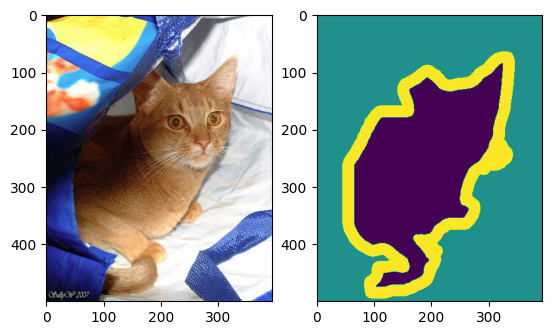

In [ ]:
image, mask = data_train[0]

print(image)

print(mask)

# print(type(image))
# print(mask.dtype)

plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()


In [ ]:
mask = np.array(mask)

In [ ]:
np.unique(mask)

array([1, 2, 3], dtype=uint8)

In [ ]:
class Image_Mask(Dataset):

  def __init__(self, data, transform = None):
    self.data = data
    self.tfms = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image, mask  = self.data[idx]


    # mask = np.array(mask, dtype = np.int32)

    # image = Image.open(image).convert("RGB")
    # mask = Image.open(mask).convert("RGB")



    if self.tfms is not None:
      image = self.tfms(image)
      mask = self.tfms(mask) * 255

    mask = mask.view((32,32))

    return image, mask.long()-1

In [ ]:
train_ds = Image_Mask(data_train, tfms)
test_ds = Image_Mask(data_test, tfms)

torch.Size([3, 32, 32])
torch.Size([32, 32])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
torch.float32
torch.int64
unique_datatensor([0, 1, 2])


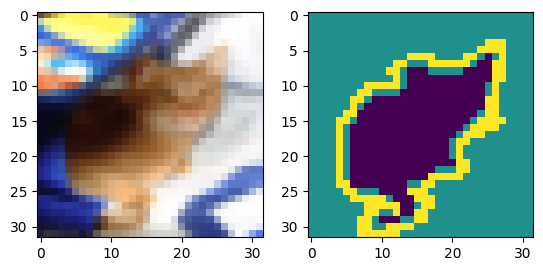

In [ ]:
image, mask = train_ds[0]

print(image.shape)
print(mask.shape)

print(mask)

print(image.dtype)
print(mask.dtype)

print(f"unique_data{torch.unique(mask)}")


plt.subplot(1,2,1)
plt.imshow(np.transpose(image,(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(mask.reshape(32,32))
plt.show()

In [ ]:
train_dl = DataLoader(dataset = train_ds, batch_size = 32, shuffle=True)
test_dl = DataLoader(dataset = test_ds, batch_size = 32, shuffle = False)

#`Model`

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(3,3),padding="same"),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
class Unet(nn.Module):
    def __init__(self, pretrained=True, out_channels=3):
        super().__init__()
        self.block1=conv(3,64)
        self.block2=conv(64,64)
        self.block3=conv(64,128)
        self.block4=conv(128,128)
        self.block5=conv(128,256)
        self.block6=conv(256,256)
        self.block7=conv(256,512)
        self.block8=conv(512,512)
        self.block9=conv(512,1024)
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0,dilation=1,ceil_mode=False)
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256+256,256)
        self.up_conv8 = up_conv(128+128, 128)
        self.conv8 = conv(128 + 128, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 +64, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(64, out_channels, kernel_size=1)





    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.maxpool(self.block2(block1))
        block3 = self.block3(block2)
        block4 = self.maxpool(self.block4(block3))
        block5 = self.block5(block4)
        block6 = self.maxpool(self.block6(block5))
        block7 = self.block7(block6)
        block8 = self.maxpool(self.block8(block7))
        block9=self.block9(block8)



        # print(block9.shape)







        x4 = self.up_conv6(block9)
        x4 = torch.cat([x4,block7],dim=1)
        x4=self.conv6(x4)
        x3 = self.up_conv7(x4)

        x3 = torch.cat([x3, block5], dim=1)
        x3 = self.conv7(x3)

        x2 = self.up_conv8(x3)
        x2 = torch.cat([x2, block3], dim=1)
        x2 = self.conv8(x2)

        x1 = self.up_conv9(x2)
        x1 = torch.cat([x1, block1], dim=1)
        x1 = self.conv9(x1)

        #x = self.up_conv10(x1)
        #x = torch.cat([x, block1], dim=1)
        #x = self.conv10(x)

        x = self.conv11(x1)
        # x = x.view((-1,32,32))

        return x




In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")


In [ ]:
model = Unet().to(device)
x=  torch.rand(size = (16,3,32,32)).to(device)
y = model(x)
print(y.shape)

torch.Size([16, 3, 32, 32])


#`Functions`

In [ ]:
mse = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params = model.parameters(),lr = 1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt,gamma = 0.9)

In [ ]:
def train(data, model, loss_fn, opt, scheduler):

  model.train()

  size = len(data.dataset)

  for b, (image, mask) in enumerate(data):
    image = image.to(device)
    mask = mask.to(device)
    mask_pred = model(image)
    # mask = mask.view((-1,50,50))
    # print(mask)
    loss = loss_fn(mask_pred, mask)
    opt.zero_grad()
    loss.backward()
    opt.step()


    if b % 100 == 0:
      print(f"loss:{loss.item()}  [{b*len(image)} | {size}]")

In [ ]:
for e in range(20):
  print(f"epoch: {e+1}=-=-=-=-=-=-=-=-=-=-=-")
  train(train_dl, model, mse, opt, scheduler)

epoch: 1=-=-=-=-=-=-=-=-=-=-=-
loss:1.2265952825546265  [0 | 3680]
loss:0.5638453364372253  [3200 | 3680]
epoch: 2=-=-=-=-=-=-=-=-=-=-=-
loss:0.5270354747772217  [0 | 3680]
loss:0.4417136311531067  [3200 | 3680]
epoch: 3=-=-=-=-=-=-=-=-=-=-=-
loss:0.452459454536438  [0 | 3680]
loss:0.3918282687664032  [3200 | 3680]
epoch: 4=-=-=-=-=-=-=-=-=-=-=-
loss:0.43721258640289307  [0 | 3680]
loss:0.4380013644695282  [3200 | 3680]
epoch: 5=-=-=-=-=-=-=-=-=-=-=-
loss:0.4366515278816223  [0 | 3680]
loss:0.39350277185440063  [3200 | 3680]
epoch: 6=-=-=-=-=-=-=-=-=-=-=-
loss:0.3620554506778717  [0 | 3680]
loss:0.3502737283706665  [3200 | 3680]
epoch: 7=-=-=-=-=-=-=-=-=-=-=-
loss:0.4538588225841522  [0 | 3680]
loss:0.3198375403881073  [3200 | 3680]
epoch: 8=-=-=-=-=-=-=-=-=-=-=-
loss:0.36892467737197876  [0 | 3680]
loss:0.3501300811767578  [3200 | 3680]
epoch: 9=-=-=-=-=-=-=-=-=-=-=-
loss:0.3416958153247833  [0 | 3680]
loss:0.2881847321987152  [3200 | 3680]
epoch: 10=-=-=-=-=-=-=-=-=-=-=-
loss:0.31506

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


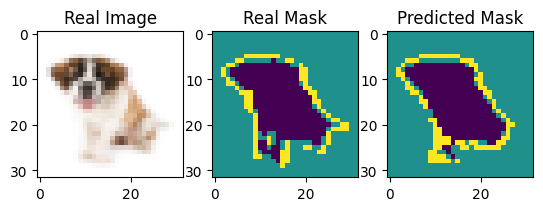

In [ ]:
image,mask = next(iter(train_dl))

image = image.to(device)
mask = mask.to(device)

plt.subplot(1,3,1)
plt.title("Real Image")
plt.imshow(image[0].cpu().permute(1,2,0))
plt.subplot(1,3,2)
plt.title("Real Mask")
plt.imshow(mask[0].cpu().view((32,32)))
print(mask[0])
plt.subplot(1,3,3)
plt.title("Predicted Mask")
mask_pred = model(image)[0].cpu().argmax(0)
print(mask_pred)
plt.imshow(mask_pred)
plt.show()

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 2, 1, 1],
        [1, 1, 1,  ..., 2, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


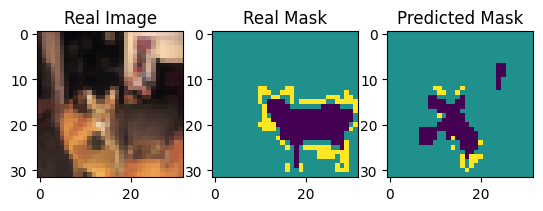

In [ ]:
image,mask = next(iter(test_dl))

image = image.to(device)
mask = mask.to(device)

plt.subplot(1,3,1)
plt.title("Real Image")
plt.imshow(image[0].cpu().permute(1,2,0))
plt.subplot(1,3,2)
plt.title("Real Mask")
plt.imshow(mask[0].cpu().view((32,32)))
print(mask[0])
plt.subplot(1,3,3)
plt.title("Predicted Mask")
mask_pred = model(image)[0].cpu().argmax(0)
print(mask_pred)
plt.imshow(mask_pred)
plt.show()